# Test the fortran functions

In [1]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import fort
%matplotlib widget

## 1. Test seach for intersections

Define a point

In [2]:
p = [.3,.5]

Define some 3D surface mesh (add noise to potentiall have several surfaces overlap)

In [3]:
_x = np.sin(np.linspace(0,np.pi,15))
_y = np.linspace(0, 1, 10)

xi, yi = np.meshgrid(_x, _y, indexing='ij')
xi += 0.3 * np.random.rand(*xi.shape)
yi += 0.3 * np.random.rand(*yi.shape)
zi = np.linspace(0, 1, len(_x))[:,None] * np.ones_like(xi)

vi = 5. * np.ones_like(xi)

Now search for the surfaces that lie along the projection in z-direction

In [4]:
matches, n_matches = fort.myfort.findpoint(xi, yi, p)
matches -= 1
print(f'{n_matches} cells found')

2 cells found


Now search for the intersection points and interpolate

In [12]:
intersect, n_inter = fort.myfort.intersect_surface(xi, yi, zi, vi, p)
intersect = intersect[:n_inter]

(0.0, 1.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
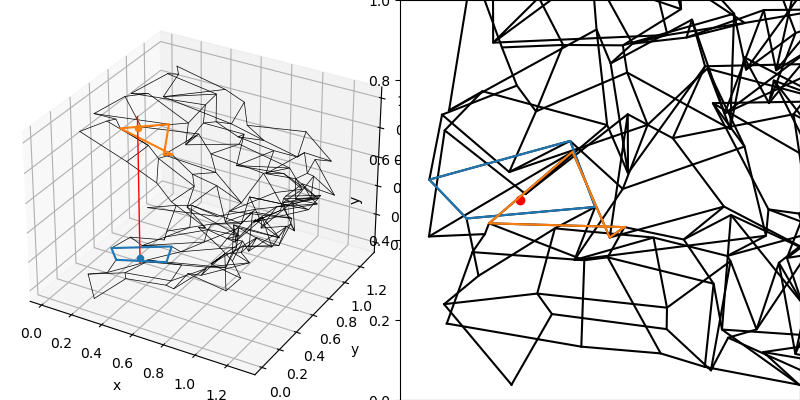

In [14]:
fig = plt.figure(figsize=(8, 4))

ax = fig.add_axes([0, 0, 0.5, 1], projection='3d')

# plot 3d mesh

for ix in range(xi.shape[0]):
    ax.plot(xi[ix, :], yi[ix, :], zi[ix, :], lw=0.5, c='k');
for iy in range(xi.shape[1]):
    ax.plot(xi[:, iy], yi[:, iy], zi[:, iy], lw=0.5, c='k');
    
# plot matches in 3d
    
for i in range(n_matches):
    ix, iy = matches[i, :]
    ax.plot(
        [xi[ix,iy], xi[ix+1,iy], xi[ix+1,iy+1], xi[ix,iy+1], xi[ix,iy]],
        [yi[ix,iy], yi[ix+1,iy], yi[ix+1,iy+1], yi[ix,iy+1], yi[ix,iy]],
        [zi[ix,iy], zi[ix+1,iy], zi[ix+1,iy+1], zi[ix,iy+1], zi[ix,iy]],
        )
    
for i in range(n_inter):
    ax.scatter(*intersect[i,:3], 'o')
    
# plot the "ray"

ax.plot([p[0], p[0]], [p[1],p[1]], [0, 1], lw=1, c='r');
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# now the same in 2D

ax = fig.add_axes([0.5, 0, 0.5, 1])

# plot the mesh
ax.plot(xi, yi, c='k')
ax.plot(xi.T, yi.T, c='k')

# plot the point
ax.plot(*p, 'ro')

# plot the squares
for i in range(n_matches):
    ix, iy = matches[i, :]
    plt.plot(
        [xi[ix,iy], xi[ix+1,iy], xi[ix+1,iy+1], xi[ix,iy+1], xi[ix,iy]],
        [yi[ix,iy], yi[ix+1,iy], yi[ix+1,iy+1], yi[ix,iy+1], yi[ix,iy]],
        )

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

## 2. Test bilinear interpolation

Define 4 points with their values

In [2]:
p00 = [1.0, 1.0, 1.0]
p10 = [2.0, 0.0, 2.0]
p11 = [3.5, 2.0, 2.0]
p01 = [1.5, 3.0, 1.0]

v00 = 1.
v10 = 2.
v11 = 3.
v01 = 2.

convert them to a 2x2 grid

In [3]:
xi, yi, zi = np.array([
    [p00, p01],
    [p10, p11]]).T

vi = np.array([
    [v00, v01],
    [v10, v11]]).T

Make the regular image grid

In [4]:
_x = np.linspace(0, 4, 20)
_y = np.linspace(0, 4, 30)
img_x, img_y = np.meshgrid(_x, _y, indexing='ij')
img_xc = 0.5 * (img_x[1:, 1:] + img_x[:-1, 1:])
img_yc = 0.5 * (img_y[1:, 1:] + img_y[1:, :-1])
img_zc = np.ones_like(img_xc)

Interpolate each pixels on the grid

In [5]:
img_z, img_v = fort.myfort.interpolate_grid(xi, yi, zi, vi, img_xc, img_yc)

In [6]:
c = [v00, v10, v11, v01, v00]
col = plt.cm.viridis(Normalize(vmin=1, vmax=3)(c))

In [7]:
points = np.array([xi.ravel(), yi.ravel()]).T
values = vi.ravel()
new_points = np.array([img_xc.ravel(), img_yc.ravel()]).T
new_values = griddata(points, values, new_points).reshape(img_xc.shape)

In [8]:
mask = ~np.isnan(new_values)
np.allclose(img_v[mask], new_values[mask])

True

Read the fortran created test data

In [9]:
xf = np.loadtxt('x.dat').reshape(20, 30)
yf = np.loadtxt('y.dat').reshape(20, 30)
zf = np.loadtxt('z.dat').reshape(20, 30)
vf = np.loadtxt('v.dat').reshape(20, 30)

<ipython-input-21-770a0b318f6d>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cc1 = axs[1].pcolormesh(xf,    yf,    vf,         vmin=1, vmax=3)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
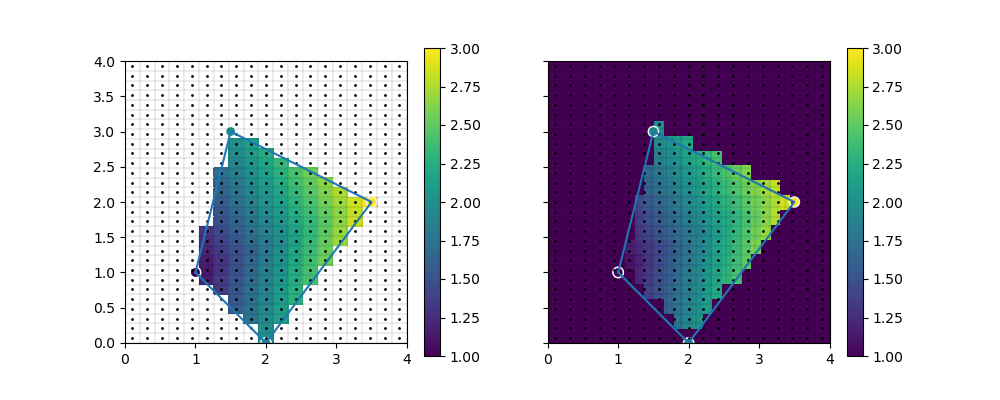

In [21]:
f, axs = plt.subplots(1, 2, dpi=100, sharex=True, sharey=True, figsize=(10, 4))
for ax in axs:
    ax.set_aspect('equal')

cc0 = axs[0].pcolormesh(img_x, img_y, new_values, vmin=1, vmax=3)
plt.colorbar(cc0, ax=axs[0])
cc1 = axs[1].pcolormesh(xf,    yf,    vf,         vmin=1, vmax=3)
#cc1 = axs[1].pcolormesh(img_x,    img_y,    img_v,         vmin=1, vmax=3)
plt.colorbar(cc1, ax=axs[1])

for ax in axs:
    ax.plot(img_x, img_y, 'k', lw=0.1)
    ax.plot(img_x.T, img_y.T, 'k', lw=0.1)
    ax.plot(img_xc, img_yc, 'ok', ms=1)
    ax.plot(*np.array([p00, p10, p11, p01, p00]).T[:2])
    ax.scatter(*np.array([p00, p10, p11, p01, p00]).T[:2], c=c, ec='w', s=55);

In [22]:
p = [3.5, 2.0, 0.0]

In [23]:
__z, __v = fort.myfort.interpolate_grid(xi, yi, zi, vi, [[p[0]]], [[p[1]]])
__v

array([[3.]])

In [24]:
Q = fort.myfort.intersect_triangle(p00, p10, p11, p)
V = fort.myfort.barycenter_interpolate(p00, p10, p11, Q, v00, v10, v11)
V

3.0

In [25]:
inter = fort.myfort.intersect_surface(xi, yi, zi, vi, p[:2], 10)[0]

In [26]:
V = fort.myfort.barycenter_interpolate(p00, p10, p11, Q, v00, v10, v11)
V

3.0

<ipython-input-27-4196131d57b9>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cc = ax.pcolormesh(xf, yf, vf)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
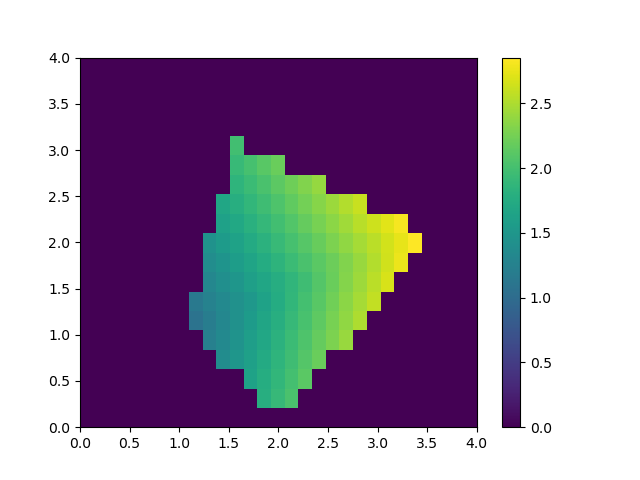

In [27]:
f, ax = plt.subplots()
cc = ax.pcolormesh(xf, yf, vf)
plt.colorbar(cc)

In [99]:
match, i = fort.myfort.intersect_surface(xi, yi, zi, vi, pt)

In [100]:
mx, my, mz, mv = match[0,:]

## 3. Test `pointintriangle`

In [25]:
pt = [2., 1.]

This should be `True`

In [26]:
bool(fort.myfort.pointintriangle(pt, p00[:2], p10[:2], p11[:2]))

True

This should be `False`

In [27]:
bool(fort.myfort.pointintriangle(pt, p00[:2], p11[:2], p01[:2]))

False

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
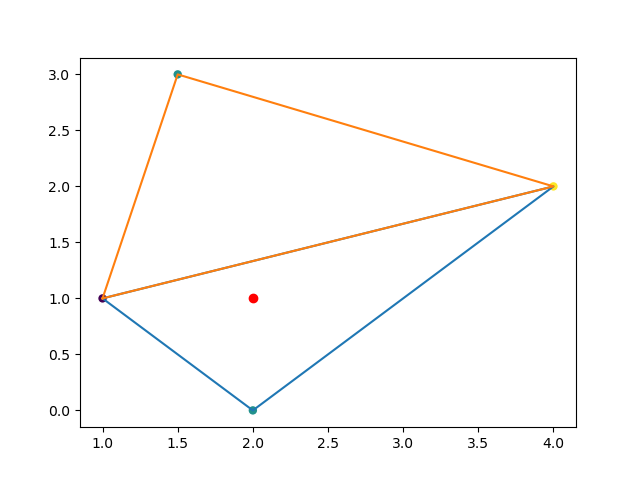

In [28]:
f, ax = plt.subplots()
ax.plot(*np.array([p00, p10, p11, p00]).T[:2]);
ax.plot(*np.array([p00, p11, p01, p00]).T[:2]);
ax.scatter(pt[0], pt[1], c='r', marker='o')
ax.scatter(*np.array([p00, p10, p11, p01, p00]).T[:2], c=c, ec='w', s=50);

## 4. Test `intersect_triangle`

In [140]:
A  = np.array([2.0, 0.0, 1.0])
B  = np.array([3.0, 2.0, 2.0])
C  = np.array([1.0, 1.5, 3.0])

VA, VB, VC = 1., 2., 3.

P = np.array([2.0, 1.0, 1.5])

Determine intersection in python and fortran

In [149]:
def intersect_tri(A, B, C, P):
    n = np.cross((B - A), (C - A))
    n = n / np.linalg.norm(n)
    d_plane = n.dot(A)
    ray = np.array([0, 0, 1])
    t = ( d_plane - n.dot(P)) / (n.dot(ray))
    Q = P + t * ray
    return Q

Qp = intersect_tri(A, B, C, P)
Qf = fort.myfort.intersect_triangle(A, B, C, P)

Check if we are identical (should return `True`)

In [150]:
np.allclose(Q, Qf)

True

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
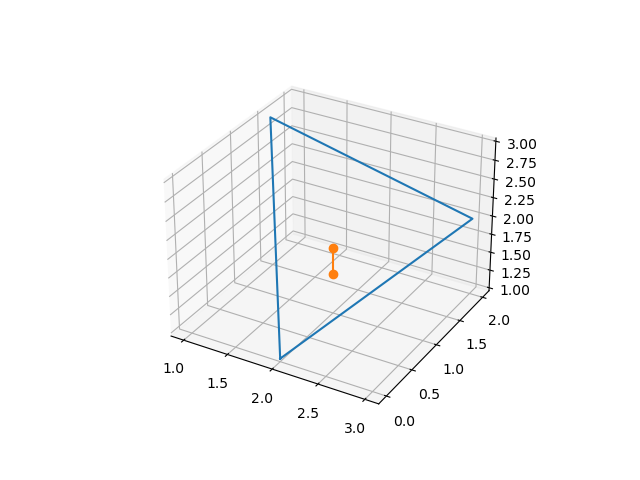

In [151]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(*np.array([A, B, C, A]).T)
ax.plot(*np.array([P, Q]).T, '-o')

Randomly place points in the triangle and color according to interpolation

In [152]:
vmin = np.array([A, B, C]).min(0)
vmax = np.array([A, B, C]).max(0)

In [176]:
norm = Normalize(vmin=1, vmax=3)

Text(0.5, 0, 'z')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
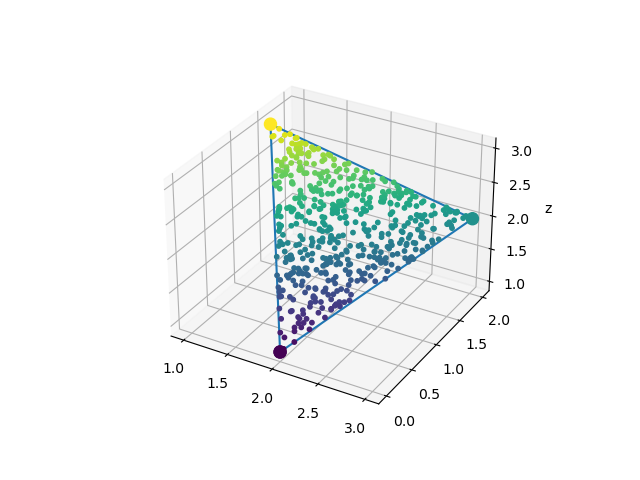

In [264]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(*np.array([A, B, C, A]).T)
ax.scatter(*np.array([A, B, C, A]).T, c=plt.cm.viridis(norm([VA, VB, VC, VA])), s=75, alpha=1)

n_p = 500
points     = np.zeros([n_p, 3])
intersects = np.zeros([n_p, 4])

for i in range(n_p):
    p_random = [np.nan, np.nan, np.nan]
    while not fort.myfort.pointintriangle(p_random[:2], A[:2], B[:2], C[:2]):
        p_random = vmin + np.random.rand(3) * (vmax - vmin)
        
    #intersect = intersect_tri(A, B, C, p_random)
    intersect = fort.myfort.intersect_triangle(A, B, C, p_random)
    value = fort.myfort.barycenter_interpolate(A, B, C, intersect, VA, VB, VC)
    
    points[i, :3] = p_random
    intersects[i, 0:3] = intersect
    intersects[i, 3] = value

ax.scatter(*intersects[:, :3].T, c=plt.cm.viridis(norm(intersects[:, 3])), s=10, alpha=1)
ax.set_zlabel('z')